In [65]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import laplace_asymmetric

In [74]:
def simulate_data(T, alpha, beta, gamma, theta):
    np.random.seed(123)
    X = np.zeros(T)
    Y = np.zeros(T)

    # Generate X values from N(0, 1)
    X[0] = np.random.normal(0, 1)

    # Generate Y values
    for t in range(1, T):
        epsilon_t = np.random.randn()
        epsilon_t_lag = np.roll(epsilon_t, 1)
        X[t] = np.random.normal(0, 1)
        Y[t] = alpha + beta * Y[t - 1] + gamma * X[t] + epsilon_t + theta * epsilon_t_lag

    return pd.DataFrame({'X': X, 'Y': Y})

# Set the parameters for each quantile level
quantiles = [0.1, 0.5, 0.9]
parameters = {
    0.1: {'alpha': -0.2, 'beta': 0.3, 'gamma': 0.2, 'theta': 0.9},
    0.5: {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.3, 'theta': 0.9},
    0.9: {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.4, 'theta': 0.9}}

T = 334

df = pd.DataFrame()

# Simulate data for each quantile level and concatenate into a single DataFrame
for quantile in quantiles:
    params = parameters[quantile]
    data = simulate_data(T, params['alpha'], params['beta'], params['gamma'], params['theta'])
    df = pd.concat([df, data], ignore_index=True)
print(df)


             X         Y
0    -1.085631  0.000000
1     0.282978  1.751552
2    -0.578600 -2.652214
3    -2.426679  1.656729
4     1.265936 -0.264728
...        ...       ...
997  -2.187086 -0.074237
998  -1.271747  0.128640
999  -0.679828  1.837661
1000 -0.008903  0.733277
1001 -0.169744  2.143205

[1002 rows x 2 columns]


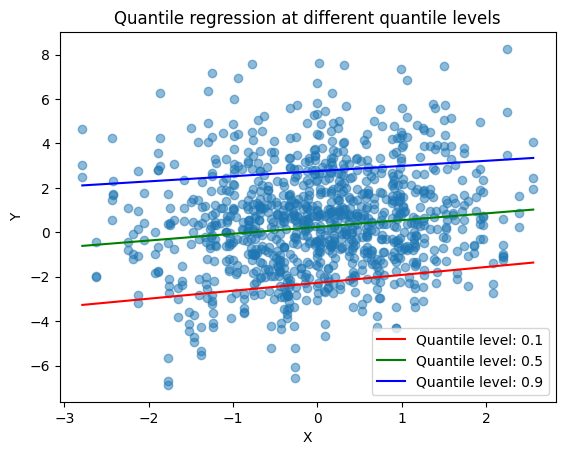

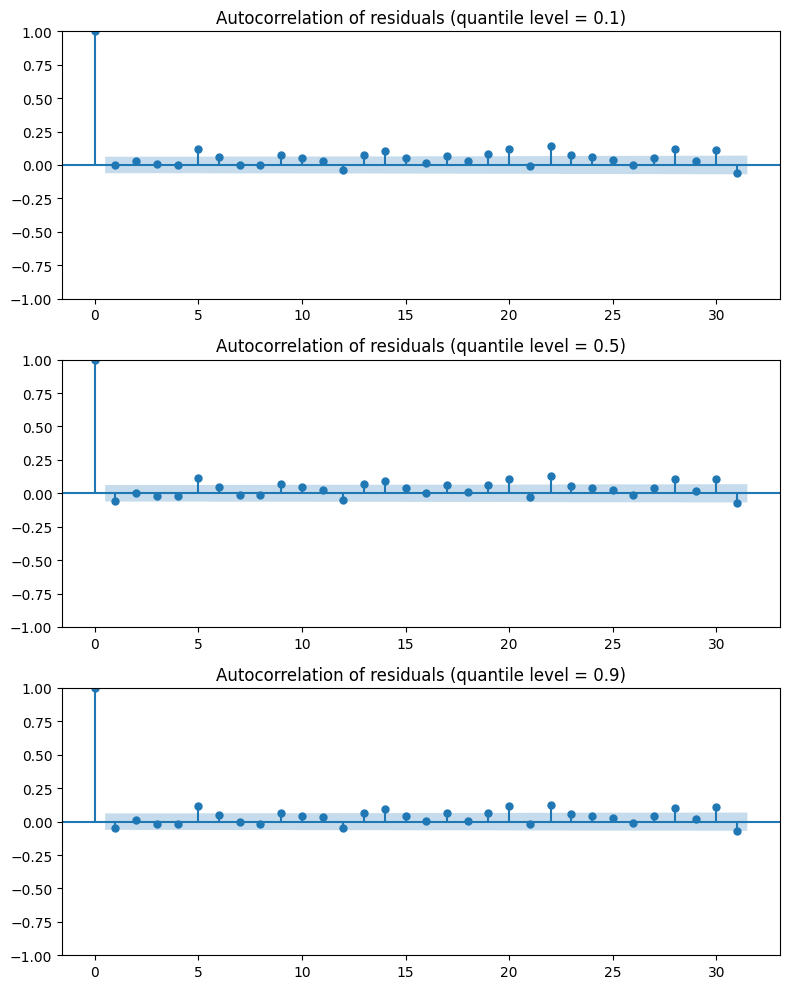

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.1422
 Model:                       QuantReg   Bandwidth:                      0.7732
 Method:                 Least Squares   Sparsity:                        11.28
 Date:                Sat, 24 Jun 2023   No. Observations:                 1002
 Time:                        16:06:17   Df Residuals:                      999
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -2.2763      0.108    -20.990      0.000      -2.489      -2.064
 x1             0.5197      0.034     15.483      0.000       0.454       0.586
 x2             0.3564      0.097      3.668      0.000       0.166   

In [75]:
################################ Quantile linear regression with package ################################
def fit_quantile(df):
    y = df['Y'].values.astype(float)
    x = df['X'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 250)

    # Plot the regression lines
    ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

fit_quantile(df)

In [ ]:
#True
#p=0.1 -0.2, 0.3, 0.2, 0.9
#p=0.5 0.2, 0.5, 0.3, 0.9
#p=0.9 0.6, 0.7, 0.4, 0.9

#Package
#p=0.1 -2.2763, 0.5197, 0.3564
#p=0.5 0.2388, 0.5780, 0.3056
#p=0.9 2.7531, 0.5675, 0.2313

In [76]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['Y'].values
    T = min(M, len(y_dataset))
    y = df['Y'].values[:T]
    x = df['X'].values[:T]  # extract data
    #epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration

        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon, 1)
        epsilon_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")


In [77]:
M=1000
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.2526742480462547]
OLS beta_hat:  [0.45893765600712555]
OLS gamma_hat:  [0.35538915887210537]
OLS theta_hat:  [0.9999999999999997]
GLS alpha_hat:  [0.23859574007303636]
GLS beta_hat:  [0.4888490777272514]
GLS gamma_hat:  [0.3565230198709536]
GLS theta_hat:  [1.000000000000002]
OLS_bias_param_0 = -0.0527
OLS_bias_param_1 = 0.0411
OLS_bias_param_2 = -0.0554
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.0662
GLS_bias_param_0 = -0.0386
GLS_bias_param_1 = 0.0112
GLS_bias_param_2 = -0.0565
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.0608


In [173]:
def Laplace_estimation(df, p, M, params0, actuals):

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['Y'].values
    T = min(M, len(y_dataset))
    y = df['Y'].values[:T]
    x = df['X'].values[:T]  # extract data
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    def log_l_Asym_Lap(params, X, y):
        α, β, γ = params  # Separate the parameters
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1 - p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2 * p) / p * (1 - p)
        
        # Calculate the log-likelihood
        #ll -= np.sum(np.log(np.sqrt(τ_2) * np.sqrt(z)) + 0.5 * ((y - α - β * X[:, 1] - γ * X[:, 2]) ** 2) / (τ_2 * z))
        #ll -= np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(((y - X @ params - θ * z)**2)/(np.sqrt(τ_2)*np.sqrt(z))**2))
        #ll -= np.sum(np.log(np.sqrt(z)) + 0.5 * ((y - α - β * X[:, 1] - γ * X[:, 2]) ** 2) / (τ_2 * z))
        #ll -= np.log(np.sum(np.sqrt(z))) - 0.5 * np.sum(((y - α - β * X[:, 1] - γ * X[:, 2] - θ * z) ** 2) / (τ * np.sqrt(z))**2)
        ll = -0.5 * np.sum(np.log(z) - np.log(τ**2 * z) - ((y - α - β * X[:, 1] - γ * X[:, 2] - θ * z) ** 2)/ (τ**2 * z))
        return -ll

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
    
        #params0 = np.array([0.2, 0.5, 0.3], dtype=float)  # Reshape to 1D array
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Powell')  # minimize the negative log-likelihood
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1
        
        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix


In [174]:
#Estimation at p=0.5 and T=100
params0 = np.array([0.15, 0.45, 0.35], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation(df, 0.5, 100, params0, actuals)

Beta Matrix:
[[ 1.65358827e+19  9.94565250e+18 -1.04476974e+19]
 [ 3.77370548e+05  2.26985588e+04  1.24542356e+05]
 [-5.38622800e+14 -3.36133921e+14  9.72203538e+16]
 [ 3.71629262e+20  1.21333774e+20  8.76675672e+19]
 [-1.78747926e+10  2.25544673e+11  1.24526609e+10]
 [-5.98922305e+09  2.19755640e+10 -1.15639310e+11]
 [ 8.11660583e+03  1.29301121e+03  8.38586332e+02]
 [-3.35938239e+02  7.23875667e-01  6.62852389e-01]
 [-1.74668715e+01  3.53014778e+03  7.22201832e-01]
 [ 3.51962055e+01  1.33485287e+00  1.96803400e+00]
 [-4.10151534e+13  3.31266723e+15  1.05334558e+14]
 [ 2.12747120e+01  2.39951737e+01  4.84163340e+00]
 [-5.96517619e+07  2.09469158e+08  1.33924317e+07]
 [ 4.80313456e+03  1.23768416e+04  3.64635554e+03]
 [ 2.02124028e+00  1.39556592e+01  6.14740976e+00]
 [ 4.14999998e+00  6.91398606e+00  9.62302833e-01]
 [ 5.21062223e+00  1.10819277e+01  2.57052276e+00]
 [ 9.69085915e-01  1.54424900e+02  6.68039311e+00]
 [ 1.05979579e+01  1.59912760e+00  1.45841730e+00]
 [ 2.84644690e+08 

In [175]:
#Estimation at p=0.5 and T=250
params0 = np.array([0.15, 0.45, 0.35], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation(df, 0.5, 250, params0, actuals)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_optimize.py:3384: RuntimeWarning: overflow encountered in double_scalars
  t *= temp*temp
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_optimize.py:3386: RuntimeWarning: overflow encountered in double_scalars
  t -= delta*temp*temp
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_optimize.py:3386: RuntimeWarning: invalid value encountered in double_scalars
  t -= delta*temp*temp


Beta Matrix:
[[ 9.37693419e+28  8.22059353e+28  8.56781539e+28]
 [ 7.74595196e-01  7.36982646e+00 -2.86534563e+00]
 [ 4.63863522e+06 -6.31704718e+04 -1.65462423e+05]
 [ 2.72599588e+17  8.76669070e+16 -3.41397191e+20]
 [ 9.93167906e+16 -5.42037413e+15  1.41532057e+18]
 [ 4.68851623e+12  2.81316962e+11 -3.43579071e+11]
 [ 1.13032130e+23  4.50000000e-01 -3.16661645e+22]
 [-1.64984850e+08  1.06568930e+12 -4.29114457e+09]
 [ 4.83084203e+01  3.17063689e+00  4.93696061e+00]
 [ 2.27242781e+04  1.23068993e+03  4.59731817e+01]
 [ 1.72036465e+13 -5.34089814e+11  3.99007100e+13]
 [ 5.25683094e+00  5.73916242e+01  2.02686768e+00]
 [ 1.15000000e+00  2.23906346e+01  1.11393203e+00]
 [-1.90616117e+09  4.23960621e+12 -9.68961377e+09]
 [ 1.16331465e+01  8.31966025e-01  4.99904213e-01]
 [ 3.65959799e+14 -1.63186376e+11 -1.06636499e+11]
 [-7.40247044e+17  2.47181335e+20 -2.75994112e+18]
 [ 3.24779259e+36  2.78747728e+34  6.68979311e+37]
 [ 1.82658231e-01  1.07942035e+01  2.40505228e+00]
 [ 8.52035691e+07 

In [176]:
#Estimation at p=0.5 and T=1000  #Package #p=0.5 0.2388, 0.5780, 0.3056
params0 = np.array([0.2, 0.5, 0.3], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation(df, 0.5, 1000, params0, actuals)

Beta Matrix:
[[ 1.65110603e+08  1.70223191e+10  3.18646162e+07]
 [ 2.07422246e+02  5.17506754e+02  1.28977115e+02]
 [ 1.03951326e+07  5.20785258e+07 -6.14698136e+06]
 ...
 [ 1.96823772e+09  1.65106226e+07  1.60760511e+07]
 [ 1.80487840e+00  2.52618037e+00  2.02684226e+00]
 [-6.10259956e+08 -2.97926885e+10  2.26901641e+08]]

RMSE Matrix:
[[9.82832004e+09 9.82832004e+09 9.82832004e+09]
 [3.30047897e+02 3.30047897e+02 3.30047897e+02]
 [3.08653903e+07 3.08653903e+07 3.08653903e+07]
 ...
 [1.13644046e+09 1.13644046e+09 1.13644046e+09]
 [1.79471685e+00 1.79471685e+00 1.79471685e+00]
 [1.72049236e+10 1.72049236e+10 1.72049236e+10]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[3.85842266e+61 5.47740537e+60 1.00247348e+60]

Mean of RMSE:
2.4953735608279063e+61


In [146]:
#Estimation at p=0.1 and T=100
params0 = np.array([-0.2, 0.3, 0.2], dtype=float) 
actuals = np.array([-0.2, 0.3, 0.2])
result_matrix = Laplace_estimation(df, 0.1, 100, params0, actuals)

Beta Matrix:
[[-0.61224378 -0.28516823  1.69020994]
 [ 2.22663475  0.09476585  0.84998556]
 [-0.26868242  0.58686752  0.20618037]
 [-0.83242624 -0.34571341  0.78359215]
 [-1.14427194  0.03977644  0.38033988]
 [-0.4384722   0.1396661   0.08065839]
 [ 0.65410197  0.32840309  1.2       ]
 [-0.19997475  0.35572809  1.2       ]
 [-0.10983006 -0.31803397 -1.04998003]
 [ 0.35652813  0.78490778 -0.26568207]
 [ 0.38456207 -0.30812645  1.963932  ]
 [ 0.49779392  0.07209513  0.99837385]
 [-0.22749747 -0.2379357  -2.4919427 ]
 [ 0.14640765  0.17879202  2.70657779]
 [-0.2         2.55842864  0.2       ]
 [-0.20000003  0.48272786  0.93325121]
 [-0.05410197 -0.45580144  0.64207103]
 [-0.33197894  0.89696049  0.82145257]
 [-2.31778002  0.4846598   1.42988766]
 [ 0.01279296 -0.6575399   0.44501554]
 [-0.20618031 -0.26145597  0.8179755 ]
 [ 1.34738774 -0.28969337  0.12114114]
 [-0.64763731 -0.44091563  0.19034928]
 [ 1.06209829  0.67454306  0.20000003]
 [ 1.40185364  0.18854383  1.33820268]
 [-0.8180339

In [147]:
#Estimation at p=0.1 and T=250
params0 = np.array([-0.2, 0.3, 0.2], dtype=float) 
actuals = np.array([-0.2, 0.3, 0.2])
result_matrix = Laplace_estimation(df, 0.1, 250, params0, actuals)

Beta Matrix:
[[-7.42187812e-01  6.04772503e-01  8.31313329e-01]
 [ 2.41803397e+00 -6.02635412e-01  6.89478216e-01]
 [-8.37003623e-01  2.99278131e-01  1.20000000e+00]
 [-1.30396434e+00  2.50621897e-01  8.61926206e-01]
 [-1.81803400e+00  6.81966000e-01  8.18034000e-01]
 [-3.30426013e+00  5.42858367e-01  3.01447662e+00]
 [-1.69490345e+00  3.23088112e-01  2.23380391e+00]
 [ 8.04806704e-01  1.85799809e-01  1.98521823e+00]
 [-5.55673574e-02  5.03975696e-01  7.82329785e-01]
 [ 1.44048909e-01  6.16964835e-01  4.39361717e-01]
 [ 8.15091102e-01  1.98572254e-01 -7.84628669e-02]
 [-2.08672411e-01 -9.57726428e-02  1.20000000e+00]
 [-5.98317906e-01  7.34245395e-01 -5.88752602e-01]
 [-1.14673645e+00 -1.93880362e-01  1.32260352e-01]
 [-1.65324168e+00 -8.08619137e-03  3.80504013e-01]
 [ 7.76995904e-01 -2.46511250e-01 -1.43789749e-01]
 [ 1.37671271e+00  1.30000000e+00  3.78420498e-01]
 [-2.09280163e+00 -2.84487632e-01  5.81966000e-01]
 [ 5.90585940e-01  1.19473097e+00  1.22964376e+00]
 [ 6.87787083e-01 

In [148]:
#Estimation at p=0.1 and T=1000
params0 = np.array([-0.2, 0.3, 0.2], dtype=float) 
actuals = np.array([-0.2, 0.3, 0.2])
result_matrix = Laplace_estimation(df, 0.1, 1000, params0, actuals)

Beta Matrix:
[[-0.18259619  0.65978794 -0.82458868]
 [-1.19999998  0.77213594  0.9910868 ]
 [-0.0644565   0.30953453  1.2       ]
 ...
 [-0.20000003 -0.00881239  0.24152449]
 [ 0.8         0.17001574  1.21      ]
 [-0.04094636  0.48424778 -0.50820392]]

RMSE Matrix:
[[0.6270386  0.6270386  0.6270386 ]
 [0.78501181 0.78501181 0.78501181]
 [0.58265569 0.58265569 0.58265569]
 ...
 [0.17989754 0.17989754 0.17989754]
 [0.82401374 0.82401374 0.82401374]
 [0.43235714 0.43235714 0.43235714]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[0.24334471 0.31068318 0.65323238]

Mean of RMSE:
0.7733283719237045


In [150]:
#Estimation at p=0.9 and T=100
params0 = np.array([0.6, 0.7, 0.4,], dtype=float) 
actuals = np.array([0.6, 0.7, 0.4,])
result_matrix = Laplace_estimation(df, 0.9, 100, params0, actuals)

Beta Matrix:
[[-2.32916683e+00  8.48636472e-01  8.16749959e-01]
 [ 2.16230591e+00  4.12625842e-01 -2.57581745e-01]
 [ 1.80866286e+00  2.05304324e+00  7.95833792e-01]
 [ 8.27379251e-01 -1.61786167e-01 -2.97901839e-01]
 [-1.41485043e+00  8.91393311e-02  1.37993209e+00]
 [ 2.81316560e+00 -6.36011702e-01  9.32741777e-01]
 [-1.48815868e+00 -5.36067950e-01  3.50614457e-01]
 [-3.45617874e-01  1.37694075e-01  9.85360969e-01]
 [ 2.55792189e-01  5.52039767e-01 -1.00768829e+00]
 [ 1.88442093e+00  1.37583925e+00  1.18751236e+00]
 [-1.00408889e+00 -6.39502854e-02  4.70967615e-01]
 [ 6.35236072e-01 -6.28025214e-01  2.42006723e-01]
 [ 1.31202360e+00  2.68546540e-01  2.88729392e+00]
 [ 2.24319818e+00 -8.53260447e-02  2.03397495e+00]
 [ 2.72821752e+00 -7.20346660e-01  6.30463513e-01]
 [-3.65370392e-02  1.73272985e+00 -1.47814953e-01]
 [ 1.60000000e+00  9.36067990e-01  2.75814637e+00]
 [-1.14203567e+00  1.42711923e-01 -2.01853660e-01]
 [-4.65402217e-02 -6.08952057e-01  5.12904749e-01]
 [-1.78196600e+00 

In [151]:
#Estimation at p=0.9 and T=250
params0 = np.array([0.6, 0.7, 0.4,], dtype=float) 
actuals = np.array([0.6, 0.7, 0.4,])
result_matrix = Laplace_estimation(df, 0.9, 250, params0, actuals)

Beta Matrix:
[[ 2.16728395e+00  3.91331626e-01 -1.31549566e+00]
 [-2.01627210e+00  5.99520840e-01  8.88589563e-01]
 [-5.45898064e-01 -5.66288754e-02  1.62291239e+00]
 [-3.70651266e-01  6.12607551e-01  1.29374604e+00]
 [ 2.83606797e+00  6.81934764e-01  2.78196605e+00]
 [-8.70764564e-01 -3.91849744e-01  3.92145228e-01]
 [-6.70715076e-01 -4.40148228e-01  1.39381969e+00]
 [-2.02414128e+00  7.01930795e-01  2.40000000e+00]
 [ 7.05075546e-03  5.54101971e-01  1.27680677e+00]
 [ 5.87241478e-01 -3.12726036e-01  1.50835052e+00]
 [-7.00729011e-01 -7.76075609e-02  2.44923259e+00]
 [ 7.13475296e-01  2.67123538e-01  8.82679023e-01]
 [-1.72269232e+00 -5.19115089e-02  1.47623756e+00]
 [-1.25240260e+00  8.46071095e-01  7.73056622e-01]
 [ 4.77680856e-01  6.92218790e-01  1.38811711e+00]
 [ 3.90135453e-01  1.20410631e+00  1.88722247e+00]
 [ 2.58792981e-01  8.19660349e-02 -3.20754856e-01]
 [-1.68576352e+00  1.37512548e-01  2.45119863e+00]
 [-2.46373058e+00  8.09589071e-02  7.81966025e-01]
 [-3.51071092e-01 

In [152]:
#Estimation at p=0.9 and T=1000
params0 = np.array([0.6, 0.7, 0.4,], dtype=float) 
actuals = np.array([0.6, 0.7, 0.4,])
result_matrix = Laplace_estimation(df, 0.9, 1000, params0, actuals)

Beta Matrix:
[[ 0.34264459  0.54073082  1.21169867]
 [ 1.49336691  0.37376208  1.81347433]
 [ 1.3653503   0.48615241  1.1032049 ]
 ...
 [-0.14819496 -0.1264063   0.18026309]
 [ 1.20198992 -0.0823255   1.16176108]
 [ 1.38910199 -0.00533881 -0.48476297]]

RMSE Matrix:
[[0.50015104 0.50015104 0.50015104]
 [0.98360651 0.98360651 0.98360651]
 [0.61264155 0.61264155 0.61264155]
 ...
 [0.65600492 0.65600492 0.65600492]
 [0.7198854  0.7198854  0.7198854 ]
 [0.79644843 0.79644843 0.79644843]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[0.46575297 0.33352272 0.87124234]

Mean of RMSE:
0.8968180040131966


EM Algorithm

In [100]:
def EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals):
    random_subset = df.sample(n)
    y = random_subset['Y'].values
    x = random_subset['X'].values
    y = df['Y'].values
    x = df['X'].values
    y = np.array(y)
    x = np.array(x)
    T = len(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)
        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        #print('gamma:', gamma)
        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_
        abso = np.zeros((len(x), 1))
        for j in range(T):  
            abso[j] = np.abs(y[j] - X[j] @ β)
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(abso))
        #print('μ:', μ)
        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i+1] = 1 / mode_z_inverse
        #z[i+1] = mode_z_inverse
        #print('z[i+1]:', z[i+1])
        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

        biases = actuals - np.array(β)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE

        print("\nRMSE:")
        print(rmse)

        print("\nMean of RMSE:")
        print(np.mean(rmse))

    return β_values


In [101]:
#Package
#p=0.1 -2.2763, 0.5197, 0.3564
#p=0.5 0.2388, 0.5780, 0.3056
#p=0.9 2.7531, 0.5675, 0.2313
#True
#p=0.1 -0.2, 0.3, 0.2, 0.9
#p=0.5 0.2, 0.5, 0.3, 0.9
#p=0.9 0.6, 0.7, 0.4, 0.9

n = 100
p = 0.1
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([0.1 -0.2, 0.3, 0.2]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.1 -0.2, 0.3, 0.2])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [-7829.29649296 38329.73723599  2756.34602292]

RMSE:
22642.550027300727

Mean of RMSE:
22642.550027300727
Iteration 2: [-5.55240381e-03 -2.83605888e-03 -4.24518621e-05]

RMSE:
0.21778209147263383

Mean of RMSE:
0.21778209147263383
Iteration 3: [0.18579714 0.57078903 0.098505  ]

RMSE:
0.3065939877188812

Mean of RMSE:
0.3065939877188812
Iteration 4: [0.18513311 0.56960065 0.09870478]

RMSE:
0.3059837644088972

Mean of RMSE:
0.3059837644088972
Iteration 5: [0.18504426 0.56976543 0.09950696]

RMSE:
0.30602716911923006

Mean of RMSE:
0.30602716911923006
Iteration 6: [0.18841363 0.56967136 0.09937611]

RMSE:
0.3061832076797939

Mean of RMSE:
0.3061832076797939
Iteration 7: [0.19088835 0.56844211 0.10270521]

RMSE:
0.30563429937124376

Mean of RMSE:
0.30563429937124376
Iteration 8: [0.18788253 0.56992225 0.0987361 ]

RMSE:
0.3062945931768646

Mean of RMSE:
0.3062945931768646
Iteration 9: [0.18801408 0.56985821 0.09902097]

RMSE:
0.3062613034092097

Mean of RMSE:
0.306261303409

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.82929649e+03,  3.83297372e+04,  2.75634602e+03],
       [-5.55240381e-03, -2.83605888e-03, -4.24518621e-05],
       [ 1.85797145e-01,  5.70789032e-01,  9.85049953e-02],
       [ 1.85133109e-01,  5.69600651e-01,  9.87047806e-02],
       [ 1.85044263e-01,  5.69765429e-01,  9.95069591e-02],
       [ 1.88413634e-01,  5.69671357e-01,  9.93761078e-02],
       [ 1.90888347e-01,  5.68442109e-01,  1.02705212e-01],
       [ 1.87882526e-01,  5.69922252e-01,  9.87361032e-02],
       [ 1.88014079e-01,  5.69858212e-01,  9.90209746e-02],
       [ 1.87694993e-01,  5.69976003e-01,  9.86425798e-02],
       [ 1.79206068e-01,  5.59196984e-01,  8.82131856e-02],
       [ 1.90788409e-01,  5.73844559e-01,  1.02179289e-01],
       [ 1.90720775e-01,  5.73815356e-01,  1.02278028e-01],
       [ 1.90932429e-01,  5.73954652e-01,  1.02501529e-01],
       [ 1.94711459e-01,  5.73961485e-01,  1.02993227e-01],
       [ 1.98101564e-01,  5.72159214e-01

In [102]:
n = 1000
p = 0.1
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([0.1 -0.2, 0.3, 0.2]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.1 -0.2, 0.3, 0.2])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [-76462.73977544 374337.174045    26919.1196005 ]

RMSE:
221133.00886913846

Mean of RMSE:
221133.00886913846
Iteration 2: [-5.55164058e-03 -2.83581476e-03 -4.24758002e-05]

RMSE:
0.21778188323789097

Mean of RMSE:
0.21778188323789097
Iteration 3: [0.1857979 0.5707893 0.098505 ]

RMSE:
0.3065941600553423

Mean of RMSE:
0.3065941600553423
Iteration 4: [0.18513391 0.56960097 0.09870474]

RMSE:
0.3059839607535396

Mean of RMSE:
0.3059839607535396
Iteration 5: [0.18504508 0.56976567 0.09950684]

RMSE:
0.30602733189577047

Mean of RMSE:
0.30602733189577047
Iteration 6: [0.1884144  0.5696716  0.09937599]

RMSE:
0.3061833715191296

Mean of RMSE:
0.3061833715191296
Iteration 7: [0.1908891  0.56844235 0.10270508]

RMSE:
0.30563446363117464

Mean of RMSE:
0.30563446363117464
Iteration 8: [0.18788332 0.56992265 0.09873603]

RMSE:
0.3062948300171092

Mean of RMSE:
0.3062948300171092
Iteration 9: [0.18801483 0.56985852 0.09902085]

RMSE:
0.3062615015666952

Mean of RMSE:
0.306261501566

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.64627398e+04,  3.74337174e+05,  2.69191196e+04],
       [-5.55164058e-03, -2.83581476e-03, -4.24758002e-05],
       [ 1.85797899e-01,  5.70789304e-01,  9.85049959e-02],
       [ 1.85133912e-01,  5.69600965e-01,  9.87047379e-02],
       [ 1.85045079e-01,  5.69765666e-01,  9.95068424e-02],
       [ 1.88414405e-01,  5.69671595e-01,  9.93759928e-02],
       [ 1.90889104e-01,  5.68442346e-01,  1.02705079e-01],
       [ 1.87883321e-01,  5.69922645e-01,  9.87360299e-02],
       [ 1.88014833e-01,  5.69858524e-01,  9.90208480e-02],
       [ 1.87695825e-01,  5.69976317e-01,  9.86425312e-02],
       [ 1.79206889e-01,  5.59197220e-01,  8.82131471e-02],
       [ 1.90789342e-01,  5.73845059e-01,  1.02179222e-01],
       [ 1.90721676e-01,  5.73815733e-01,  1.02277898e-01],
       [ 1.90933264e-01,  5.73954888e-01,  1.02501409e-01],
       [ 1.94712227e-01,  5.73961717e-01,  1.02993094e-01],
       [ 1.98102275e-01,  5.72159478e-01

In [ ]:
Mean of RMSE:
0.3082794329042083
Iteration 23: [0.20350373 0.57174633 0.09659801]

Mean of RMSE:
0.3082796126032576
Iteration 23: [0.20350434 0.57174664 0.09659805]

In [106]:
#Package
#p=0.1 -2.2763, 0.5197, 0.3564
#p=0.5 0.2388, 0.5780, 0.3056
#p=0.9 2.7531, 0.5675, 0.2313
#True
#p=0.1 -0.2, 0.3, 0.2, 0.9
#p=0.5 0.2, 0.5, 0.3, 0.9
#p=0.9 0.6, 0.7, 0.4, 0.9

n = 100
p = 0.5
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([0.2388, 0.5780, 0.3056]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.2, 0.5, 0.3])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [121867.17291727 675760.72620832  41750.79233375]

RMSE:
397176.17249592044

Mean of RMSE:
397176.17249592044
Iteration 2: [2.78377564e-07 8.35282016e-07 1.43736086e-07]

RMSE:
0.35590221584821974

Mean of RMSE:
0.35590221584821974
Iteration 3: [190729.34073934 571327.41785032  98019.7795833 ]

RMSE:
352325.6086879296

Mean of RMSE:
352325.6086879296
Iteration 4: [4.77036559e-07 1.43266384e-06 2.47658693e-07]

RMSE:
0.3559019348841974

Mean of RMSE:
0.3559019348841974
Iteration 5: [ 76078.12203085 228960.33415385  40051.58851246]

RMSE:
141202.70883887098

Mean of RMSE:
141202.70883887098
Iteration 6: [3.58508916e-06 1.05828163e-05 1.84891771e-06]

RMSE:
0.3558976080495422

Mean of RMSE:
0.3558976080495422
Iteration 7: [10639.26139719 30930.37940002  5601.66308144]

RMSE:
19159.240025195464

Mean of RMSE:
19159.240025195464
Iteration 8: [0.00019934 0.00058973 0.00010222]

RMSE:
0.355624427323873

Mean of RMSE:
0.355624427323873
Iteration 9: [188.38146581 556.58942776  97.0

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.21867173e+05, 6.75760726e+05, 4.17507923e+04],
       [2.78377564e-07, 8.35282016e-07, 1.43736086e-07],
       [1.90729341e+05, 5.71327418e+05, 9.80197796e+04],
       [4.77036559e-07, 1.43266384e-06, 2.47658693e-07],
       [7.60781220e+04, 2.28960334e+05, 4.00515885e+04],
       [3.58508916e-06, 1.05828163e-05, 1.84891771e-06],
       [1.06392614e+04, 3.09303794e+04, 5.60166308e+03],
       [1.99339559e-04, 5.89732564e-04, 1.02224941e-04],
       [1.88381466e+02, 5.56589428e+02, 9.70223448e+01],
       [1.47083302e-01, 4.36532073e-01, 7.53937543e-02],
       [2.42242783e-01, 7.38225601e-01, 1.16063271e-01],
       [1.95951063e-01, 5.76998538e-01, 1.02865719e-01],
       [1.95779789e-01, 5.76865531e-01, 1.03219387e-01],
       [1.96153972e-01, 5.77111692e-01, 1.03224782e-01],
       [2.00376809e-01, 5.77132746e-01, 1.03799229e-01],
       [2.04151195e-01, 5.75126481e-01, 1.02977903e-01],
       [2.07468666e-01, 5.73843

In [107]:
n = 1000
p = 0.5
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([0.2388, 0.5780, 0.3056]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.2, 0.5, 0.3])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [1190183.29914007 6599637.22219037  407747.99785685]

RMSE:
3878917.405444611

Mean of RMSE:
3878917.405444611
Iteration 2: [2.85040106e-08 8.55273217e-08 1.47176190e-08]

RMSE:
0.3559025682062317

Mean of RMSE:
0.3559025682062317
Iteration 3: [1862715.75432667 5579742.36165934  957288.41178145]

RMSE:
3440912.200149497

Mean of RMSE:
3440912.200149497
Iteration 4: [4.88450428e-08 1.46694263e-07 2.53584326e-08]

RMSE:
0.3559025394378193

Mean of RMSE:
0.3559025394378193
Iteration 5: [ 743003.00908056 2236099.06112769  391156.48485088]

RMSE:
1379032.7082755223

Mean of RMSE:
1379032.7082755223
Iteration 6: [3.67088916e-07 1.08360891e-06 1.89316685e-07]

RMSE:
0.3559020963965312

Mean of RMSE:
0.3559020963965312
Iteration 7: [103905.87410057 302074.36286624  54707.34078416]

RMSE:
187116.66359489338

Mean of RMSE:
187116.66359489338
Iteration 8: [2.04291882e-05 6.04383676e-05 1.04764582e-05]

RMSE:
0.3558740920469056

Mean of RMSE:
0.3558740920469056
Iteration 9: [1838.1483

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.19018330e+06, 6.59963722e+06, 4.07747998e+05],
       [2.85040106e-08, 8.55273217e-08, 1.47176190e-08],
       [1.86271575e+06, 5.57974236e+06, 9.57288412e+05],
       [4.88450428e-08, 1.46694263e-07, 2.53584326e-08],
       [7.43003009e+05, 2.23609906e+06, 3.91156485e+05],
       [3.67088916e-07, 1.08360891e-06, 1.89316685e-07],
       [1.03905874e+05, 3.02074363e+05, 5.47073408e+04],
       [2.04291882e-05, 6.04383676e-05, 1.04764582e-05],
       [1.83814831e+03, 5.43096906e+03, 9.46703851e+02],
       [4.76062888e-02, 1.41291853e-01, 2.44026123e-02],
       [7.48427349e-01, 2.28080404e+00, 3.58586087e-01],
       [1.95950253e-01, 5.76998170e-01, 1.02866658e-01],
       [1.95779383e-01, 5.76865567e-01, 1.03220016e-01],
       [1.96153513e-01, 5.77111570e-01, 1.03225383e-01],
       [2.00376351e-01, 5.77132625e-01, 1.03799829e-01],
       [2.04150736e-01, 5.75126359e-01, 1.02978503e-01],
       [2.07468208e-01, 5.73843

In [ ]:
Iteration 11: [0.24224278 0.7382256  0.11606327]

RMSE:
0.29783003168921585

Iteration 12: [0.19595025 0.57699817 0.10286666]

RMSE:
0.24360365246443486